In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

In [2]:
seed = 45

In [3]:
data_category = pd.read_csv('data/info_category.csv', delimiter=';', decimal=".") 
data_category.shape

(643, 4)

In [4]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name+'.csv', delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']].abs()
    data = data[data.category>0]
    return data

In [5]:
def order_data(data):
    for index in data.index:
        #row = data.loc[index, :]
        #print(row.to_frame().T)
        for i in range(0,sections_width):
            sections_range = range(sections_heigth*i+1,sections_heigth*(i+1)+1)
            sections = data.loc[index, ['pw_'+str(i) for i in sections_range]]
            if sections[0]<5 and sections[1]<5:
                reverse = sections.iloc[::-1]
                data.loc[index, ['pw_'+str(i) for i in sections_range]] = reverse.values
        row = data.loc[index, :]

file_name = 'info_pw_2_20'
sections_width = int(file_name.split("_")[-2])
sections_heigth = int(file_name.split("_")[-1])
data20 = prepare_data(file_name, data_category)
size_m = sections_width*sections_heigth
X_values = data[['pw_'+str(i) for i in range(1,size_m+1)]]
y_values = data[['category']]
#order_data(data)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

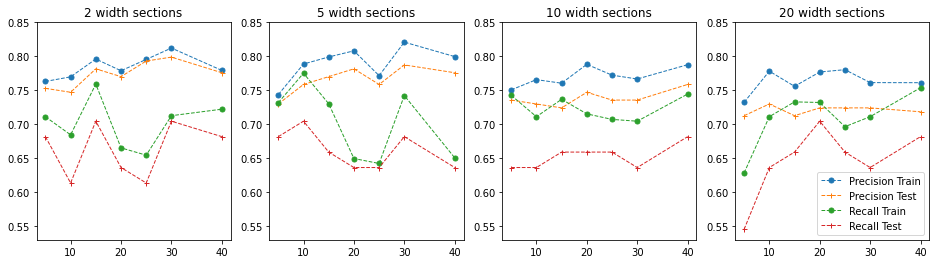

,width,range,diff_precision_recall,precision_train,recall_train,precision_test,recall_test
5,5,30,0.078607,0.820880,0.742273,0.787356,0.681818
5,2,30,0.099564,0.812215,0.712651,0.798851,0.704545
3,5,20,0.158497,0.808118,0.649621,0.781609,0.636364
6,5,40,0.149020,0.799609,0.650589,0.775862,0.636364
2,5,15,0.068886,0.799072,0.730186,0.770115,0.659091
2,2,15,0.036856,0.796006,0.759150,0.781609,0.704545
4,2,25,0.140928,0.795454,0.654526,0.793103,0.613636
1,5,10,0.013522,0.788684,0.775162,0.758621,0.704545
3,10,20,0.072913,0.788254,0.715341,0.747126,0.659091
6,10,40,0.043202,0.787692,0.744490,0.758621,0.681818


In [6]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
widths = [2,5,10,20]
sections = [5,10,15,20, 25,30,40]
final_data = pd.DataFrame()
for w in range(0,len(widths)):
    info_results = []
    for i in sections:
        file_name = 'data/info_pw_'+str(widths[w])+'_'+str(i)
        sections_width = int(file_name.split("_")[-2])
        sections_heigth = int(file_name.split("_")[-1])
        data = prepare_data(file_name, data_category)
        size_m = sections_width*sections_heigth
        X_values = data[['pw_'+str(i) for i in range(1,size_m+1)]]
        y_values = data[['category']]
        #order_data(data)
        X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
        kmeans = KNeighborsClassifier(n_neighbors=3)
        kmeans.fit(X_train, y_train.values.ravel())
        y_predict = kmeans.predict(X_train)
        precision_train = (precision_score(y_train, y_predict, average='weighted'))
        recall_train= (recall_score(y_train, y_predict, average='weighted'))
        y_predict = kmeans.predict(X_test)
        precision_test = (precision_score(y_test, y_predict, average='weighted'))
        recall_test = (recall_score(y_test, y_predict, average='weighted'))
        data_row= [ i, precision_train, recall_train,precision_test,recall_test]
        info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['range', 'precision_train', 'precision_test', 'recall_train', 'recall_test'])
    
    axs[w].plot(info_results.range,info_results.precision_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision Train')
    axs[w].plot(info_results.range,info_results.precision_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Precision Test')
    axs[w].plot(info_results.range,info_results.recall_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall Train')
    axs[w].plot(info_results.range,info_results.recall_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Recall Test')
    axs[w].title.set_text(str(widths[w])+' width sections')
    axs[w].set_ylim([0.53, 0.85])
    info_results['width'] = widths[w]
    final_data = pd.concat([final_data, info_results])
plt.legend()
plt.show()
final_data['diff_precision_recall'] = abs(final_data['precision_train'] - final_data['recall_train'])
final_data = final_data.reindex(['width','range','diff_precision_recall','precision_train', 'recall_train', 'precision_test', 'recall_test'], axis=1)
final_data.sort_values(by=['precision_train','diff_precision_recall', 'recall_train', 'precision_test', 'recall_test'], ascending=False)

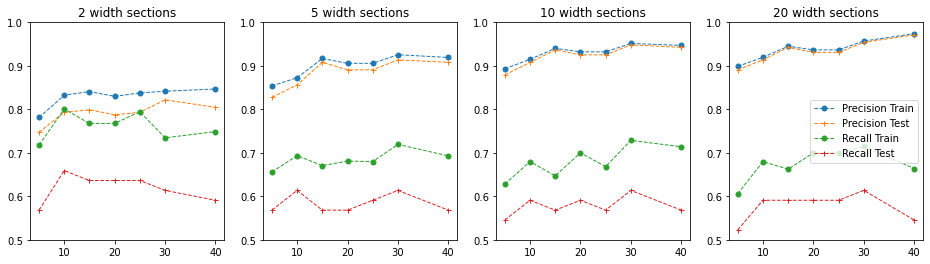

,width,range,diff_precision_recall,precision_train,recall_train,precision_test,recall_test
6,20,40,0.310013,0.973925,0.663912,0.971264,0.545455
5,20,30,0.242428,0.957030,0.714603,0.954023,0.613636
5,10,30,0.222859,0.951469,0.728610,0.948276,0.613636
6,10,40,0.233087,0.946970,0.713883,0.942529,0.568182
2,20,15,0.282676,0.945064,0.662389,0.942529,0.590909
2,10,15,0.292940,0.940077,0.647137,0.936782,0.568182
3,20,20,0.236846,0.936638,0.699791,0.931034,0.590909
4,20,25,0.236846,0.936638,0.699791,0.931034,0.590909
4,10,25,0.263895,0.932185,0.668290,0.925287,0.568182
3,10,20,0.232393,0.932185,0.699791,0.925287,0.590909


In [8]:
final_data = pd.DataFrame()
fig, axs = plt.subplots(1,4, figsize=(16,4))
widths = [2,5,10,20]
sections = [5,10,15,20, 25,30,40]
for w in range(0,len(widths)):
    info_results = []
    for i in sections:
        file_name = 'data/info_pw_'+str(widths[w])+'_'+str(i)
        sections_width = int(file_name.split("_")[-2])
        sections_heigth = int(file_name.split("_")[-1])
        data = prepare_data(file_name, data_category)
        size_m = sections_width*sections_heigth
        X_values = data[['pw_'+str(i) for i in range(1,size_m+1)]]
        y_values = data[['category']]
        #order_data(data)
        X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
        dummy_clf = SVC(C=5, class_weight='balanced')
        dummy_clf.fit(X_train, y_train.values.ravel())
        y_predict = dummy_clf.predict(X_train)
        precision_train = (precision_score(y_train, y_predict, average='weighted'))
        recall_train= (recall_score(y_train, y_predict, average='weighted'))
        y_predict = dummy_clf.predict(X_test)
        precision_test = (precision_score(y_test, y_predict, average='weighted'))
        recall_test = (recall_score(y_test, y_predict, average='weighted'))
        data_row= [ i, precision_train, recall_train,precision_test,recall_test]
        info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['range', 'precision_train', 'precision_test', 'recall_train', 'recall_test'])
    
    axs[w].plot(info_results.range,info_results.precision_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision Train')
    axs[w].plot(info_results.range,info_results.precision_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Precision Test')
    axs[w].plot(info_results.range,info_results.recall_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall Train')
    axs[w].plot(info_results.range,info_results.recall_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Recall Test')
    axs[w].title.set_text(str(widths[w])+' width sections')
    axs[w].set_ylim([0.5, 1])
    info_results['width'] = widths[w]
    final_data = pd.concat([final_data, info_results])
plt.legend()
plt.show()

final_data['diff_precision_recall'] = abs(final_data['precision_train'] - final_data['recall_train'])
final_data = final_data.reindex(['width','range','diff_precision_recall','precision_train', 'recall_train', 'precision_test', 'recall_test'], axis=1)
final_data.sort_values(by=['precision_train','diff_precision_recall', 'recall_train', 'precision_test', 'recall_test'], ascending=False)

y_predict = kmeans.predict(X_train)
print(confusion_matrix(y_train, y_predict))
print(classification_report(y_train, y_predict, digits=3, target_names=['K', 'S', 'B']))
print(precision_score(y_train, y_predict, average='weighted'))

y_predict = kmeans.predict(X_test)
print(confusion_matrix(y_test, y_predict))
#plot_confusion_matrix(kmeans, X_test, y_test) 
print(classification_report(y_test, y_predict, digits=3, target_names=['K', 'S', 'B']))

In [69]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

file_name = 'info_pw_10_30'
sections_width = int(file_name.split("_")[-2])
sections_heigth = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width*sections_heigth
X_values = data[['pw_'+str(i) for i in range(1,size_m+1)]]
y_values = data[['category']]
#order_data(data)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

parameters = {'n_neighbors':range(3,7), 'p':[1,2,4]}
svc = KNeighborsClassifier()
clf = GridSearchCV(svc, parameters, scoring='recall_weighted', cv=2)
clf.fit(X_values, y_values.values.ravel())


data = pd.DataFrame(clf.cv_results_)
data.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,0.007007,2.563000e-05,0.127164,0.001493,3,4,"{'n_neighbors': 3, 'p': 4}",0.422018,0.522936,0.472477,0.050459,1
0,0.006483,4.996061e-04,0.015458,0.000529,3,1,"{'n_neighbors': 3, 'p': 1}",0.431193,0.495413,0.463303,0.032110,2
1,0.006976,5.841255e-06,0.016462,0.000492,3,2,"{'n_neighbors': 3, 'p': 2}",0.403670,0.522936,0.463303,0.059633,2
5,0.006982,2.861023e-05,0.124172,0.000505,4,4,"{'n_neighbors': 4, 'p': 4}",0.440367,0.477064,0.458716,0.018349,4
11,0.006514,4.636049e-04,0.124633,0.000027,6,4,"{'n_neighbors': 6, 'p': 4}",0.449541,0.458716,0.454128,0.004587,5
4,0.006480,4.435778e-04,0.015462,0.000502,4,2,"{'n_neighbors': 4, 'p': 2}",0.431193,0.458716,0.444954,0.013761,6
7,0.005983,1.192093e-07,0.014960,0.000000,5,2,"{'n_neighbors': 5, 'p': 2}",0.422018,0.458716,0.440367,0.018349,7
6,0.006482,4.988909e-04,0.014462,0.000499,5,1,"{'n_neighbors': 5, 'p': 1}",0.449541,0.412844,0.431193,0.018349,8
9,0.006980,4.649162e-06,0.015930,0.000967,6,1,"{'n_neighbors': 6, 'p': 1}",0.458716,0.403670,0.431193,0.027523,8
3,0.006454,5.280972e-04,0.014989,0.000029,4,1,"{'n_neighbors': 4, 'p': 1}",0.458716,0.394495,0.426606,0.032110,10


In [15]:
k_values = range(3,22)
precision = []
recall = []
f1 = []
acc= []
for k in k_values:
    kmeans = KNeighborsClassifier(n_neighbors=k)
    kmeans.fit(X_train, y_train.values.ravel())
    y_pred = kmeans.predict(X_test)
    
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))
    
    acc.append(accuracy_score(y_test.values.ravel(), y_pred))
print(acc)

[0.6363636363636364, 0.6590909090909091, 0.6136363636363636, 0.6136363636363636, 0.6136363636363636, 0.6136363636363636, 0.6590909090909091, 0.6590909090909091, 0.6136363636363636, 0.5909090909090909, 0.6136363636363636, 0.6363636363636364, 0.6136363636363636, 0.6363636363636364, 0.6818181818181818, 0.6363636363636364, 0.6363636363636364, 0.6136363636363636, 0.6363636363636364]


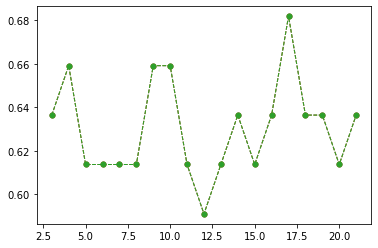

In [16]:

plt.plot(k_values,precision,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision')
plt.plot(k_values,recall,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall')
plt.plot(k_values,f1,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='F1')

#plt.plot(k_values,acc,marker='o',linestyle='dashed',linewidth=1,markersize=5, label="Accuracy")
plt.show()


In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_predict = dummy_clf.predict(X_test)

print(accuracy_score(y_test.values.ravel(), y_predict))

data_categories = pd.read_csv('info_data.csv', delimiter=';', decimal=",") 
data_categories['category'] =data_categories.apply(lambda row: 3 if (row['Potential section']==1) else 0 if (row.K==1) else 1 if (row.S==1) else 2 if (row.B==1) else 3, axis=1)

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_values], axis = 1)

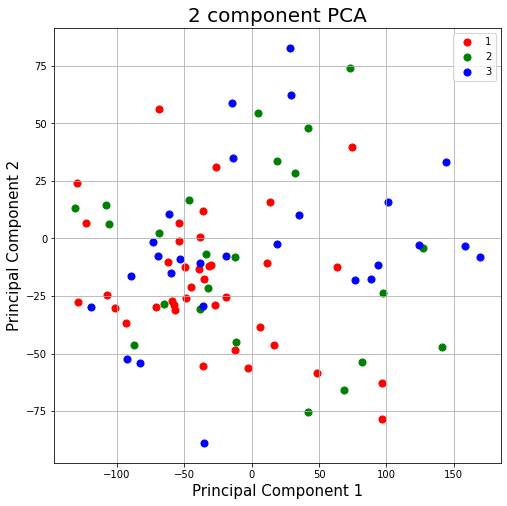

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
from sklearn.svm import SVC
dummy_clf = SVC(kernel='poly', gamma='auto')
dummy_clf.fit(principalDf[['principal component 1', 'principal component 2']], y_values)

y_predict = dummy_clf.predict(principalDf)
print(classification_report(y_train, y_predict, digits=3, target_names=['K', 'S', 'B']))

y_predict = dummy_clf.predict(X_test)
print(classification_report(y_test, y_predict, digits=3, target_names=['K', 'S', 'B']))

c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [10]:
data.sort_values(by=['RUSTICO+houghLine'])
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

KeyError: 'RUSTICO+houghLine'

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataK.index, dataK['RUSTICO+houghLine'], 'o', color='red')
plt.plot(dataS.index, dataS['RUSTICO+houghLine'], 'o', color='blue')
plt.plot(dataB.index, dataB['RUSTICO+houghLine'], 'o', color='green')

In [ ]:
data.sort_values(by=['SOCO2020'])
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataK.index, dataK['SOCO2020'], 'o', color='red')
plt.plot(dataS.index, dataS['SOCO2020'], 'o', color='blue')
plt.plot(dataB.index, dataB['SOCO2020'], 'o', color='green')

In [ ]:
X = np.array(data['RUSTICO+houghLine'])
X = X.reshape((X.shape[0],1))
y = np.array(data['category'])

In [ ]:
def total_internal_ss(X, centers, clusters):
    total = 0
    for i in range(0,clusters.shape[0]):
        dist_squared = sum([(a_i - b_i)**2 for a_i,b_i in zip(X[i], centers[clusters[i]])])
        total += dist_squared ** 2
    return total

In [ ]:
data_x = range(3,15)
data_y = []
for k in data_x:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_
    clusters = kmeans.labels_
    total = total_internal_ss(X,centers, clusters)
    data_y.append(total)
print(data_y)

In [ ]:
plt.plot(data_x,data_y, marker='o')
plt.xlabel('k')
plt.ylabel('Total sum of squares')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(X)
centers = kmeans.cluster_centers_
clusters = kmeans.labels_

In [ ]:
data_values = []
data_type = []
for i in range(0,centers.shape[0]):
    total = [0,0,0]
    for j in range(0,clusters.shape[0]):
        if (clusters[j]==i):
            total[y[j]-1] += 1
    data_values.append(total)
    data_type.append(total.index(max(total)))
print(data_values)
print(data_type)

In [ ]:
data.sort_values(by=['RUSTICO+houghLine']) 
data = data.reset_index(drop=True)
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(dataK.index, dataK['RUSTICO+houghLine'], 'o', color='red')
plt.plot(dataS.index, dataS['RUSTICO+houghLine'], 'o', color='blue')
plt.plot(dataB.index, dataB['RUSTICO+houghLine'], 'o', color='orange')
for i in range(0,centers.shape[0]):
    plt.axhline(y=centers[i])